Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, preprocessing
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
import glob

2024-03-13 15:11:18.787410: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 15:11:18.844559: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 15:11:18.844606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 15:11:18.847593: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-13 15:11:18.858841: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 15:11:18.859605: I tensorflow/core/platform/cpu_feature_guard.cc:1

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/home/chinu/Desktop/MLAI/Course 8- Deep Learning/4. Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/home/chinu/Desktop/MLAI/Course 8- Deep Learning/4. Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## train dataset - using seed=123, and using tf.keras.preprocessing.image_dataset_from_directory
## resizing images to the size img_height*img_width, while writting the dataset
train_ds = preprocessing.image_dataset_from_directory(directory=data_dir_train, 
                                                      image_size=(img_height, img_width), 
                                                      batch_size=batch_size, 
                                                      validation_split=0.2, 
                                                      subset='training',
                                                      seed=123)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Validation dataset - using seed=123, and using tf.keras.preprocessing.image_dataset_from_directory
## resizing images to the size img_height*img_width, while writting the dataset
val_ds = preprocessing.image_dataset_from_directory(directory=data_dir_train, 
                                                      image_size=(img_height, img_width), 
                                                      batch_size=batch_size, 
                                                      validation_split=0.2, 
                                                      subset='validation',
                                                      seed=123)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List of all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

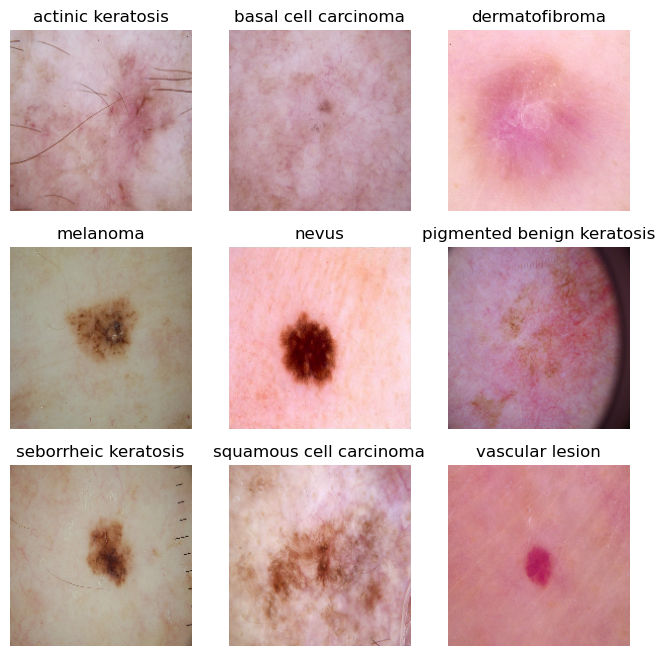

In [11]:
import matplotlib.pyplot as plt

def collect_sample_images(train_ds):
    sample_imgs = {}
    for images, labels in train_ds:
        for index, label in enumerate(labels):
            if label.numpy() not in sample_imgs:
                sample_imgs[label.numpy()] = images[index]
                if len(sample_imgs) == 9:
                    return sample_imgs
                    
                
sample_imgs = collect_sample_images(train_ds)
plt.figure(figsize=(8,8))
for label, img in sample_imgs.items():
    plt.subplot(3, 3, label + 1)
    plt.imshow(img.numpy().astype('uint8'))
    plt.title(class_names[label])
    plt.axis('off')
plt.show()

In [12]:
## Creating One - hot encoding for labels
num_classes = len(class_names)


def one_hot_encode_label(img, label):
    label = tf.one_hot(label, num_classes)
    return img, label


train_ds = train_ds.map(one_hot_encode_label)
val_ds = val_ds.map(one_hot_encode_label)
    

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model


In [14]:
num_classes = len(class_names)
model = Sequential([
    layers.experimental.preprocessing.Rescaling(scale=1. / 255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

### Compile the model

In [15]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


56/56 [==============================] - 23s 340ms/step - loss: 2.0301 - accuracy: 0.2366 - val_loss: 1.7999 - val_accuracy: 0.3490
Epoch 2/20
56/56 [==============================] - 22s 396ms/step - loss: 1.6019 - accuracy: 0.4431 - val_loss: 1.5025 - val_accuracy: 0.4989
Epoch 3/20
56/56 [==============================] - 24s 423ms/step - loss: 1.3721 - accuracy: 0.5100 - val_loss: 1.3823 - val_accuracy: 0.5459
Epoch 4/20
56/56 [==============================] - 22s 386ms/step - loss: 1.2946 - accuracy: 0.5402 - val_loss: 1.3579 - val_accuracy: 0.5414
Epoch 5/20
56/56 [==============================] - 21s 376ms/step - loss: 1.2472 - accuracy: 0.5597 - val_loss: 1.4241 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 21s 378ms/step - loss: 1.1120 - accuracy: 0.6099 - val_loss: 1.3415 - val_accuracy: 0.5884
Epoch 7/20
56/56 [==============================] - 23s 412ms/step - loss: 0.9833 - accuracy: 0.6523 - val_loss: 1.4328 - val_accuracy: 0.5503
Epoch 8/20

### Visualizing training results

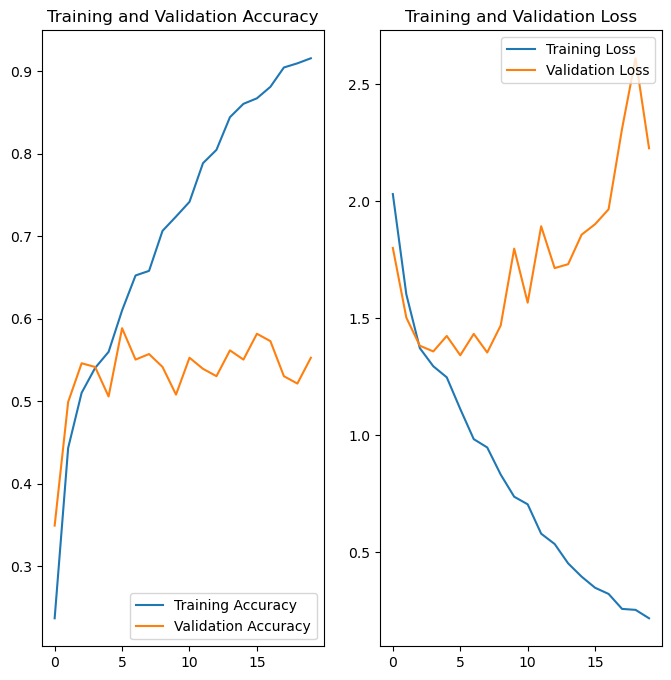

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### My findings after the model fit  
- The model is overfit.  
- Training Accuracy is 91.5%.  
- Validation accuracy is just 55.3%.  
- Model is performing very well on training data but it is not perforing well on Validation data.

### Write your findings here

In [19]:
# Handling Ovefitting of the model by using some augmentation strategies.
# used strategies - Horizontal and vertical flip, rotation and ronadom zoom in and zoom out.
  
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.5, 0.2)
])

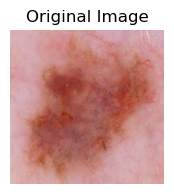

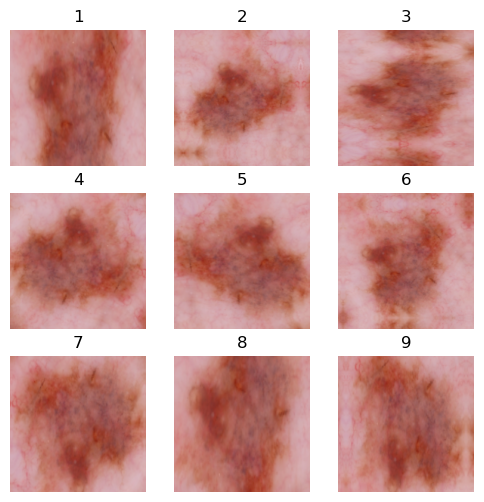

In [36]:
# visualizing how augmentation strategy works for one instance of training image.

images, labels = next(iter(train_ds)) 

plt.figure(figsize=(2,2))
plt.imshow(images[0].numpy().astype('uint8'))
plt.title('Original Image')
plt.axis('off')

plt.figure(figsize=(6,6))
for i in range(9):
  augmented_image = data_augmentation(images[0:1])
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype(int))
  plt.title(i + 1)
  plt.axis("off")

### Create the model, compile and train the model


In [37]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

# num_classes = 9
model = Sequential([
    layers.experimental.preprocessing.Rescaling(scale=1. / 255, input_shape=(img_height, img_width, 3)),
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])


### Compiling the model

In [38]:
## Your code goes here
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

### Training the model

In [39]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 24s 403ms/step - loss: 2.3097 - accuracy: 0.1758 - val_loss: 2.1046 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 28s 493ms/step - loss: 2.0490 - accuracy: 0.1802 - val_loss: 1.9845 - val_accuracy: 0.2662
Epoch 3/20
56/56 [==============================] - 27s 475ms/step - loss: 1.9509 - accuracy: 0.2595 - val_loss: 1.8728 - val_accuracy: 0.2483
Epoch 4/20
56/56 [==============================] - 27s 481ms/step - loss: 1.8028 - accuracy: 0.3661 - val_loss: 1.8233 - val_accuracy: 0.3624
Epoch 5/20
56/56 [==============================] - 28s 499ms/step - loss: 1.7411 - accuracy: 0.3811 - val_loss: 1.5701 - val_accuracy: 0.4676
Epoch 6/20
56/56 [==============================] - 35s 632ms/step - loss: 1.6873 - accuracy: 0.3884 - val_loss: 1.5845 - val_accuracy: 0.4452
Epoch 7/20
56/56 [==============================] - 28s 505ms/step - loss: 1.6722 - accuracy: 0.4046 - val_loss: 1.5586 - val_accuracy: 0.4318

### Visualizing the results

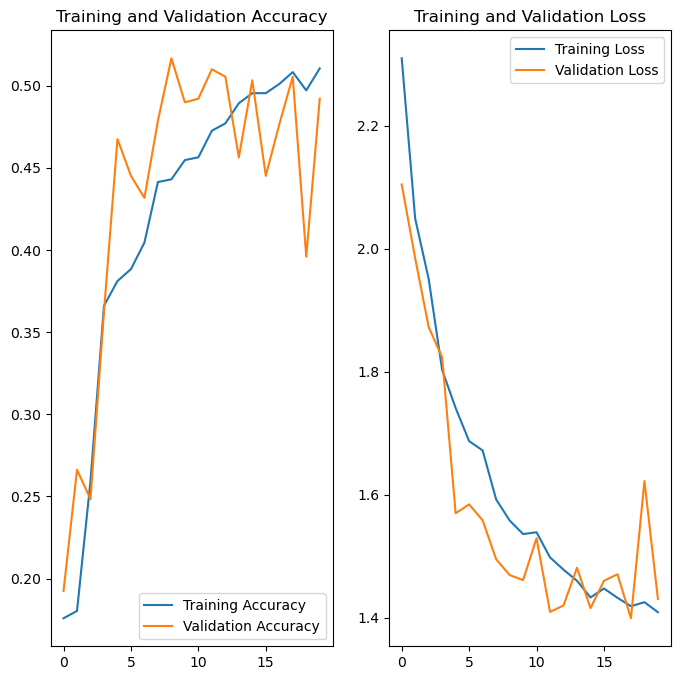

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### My findings after the model fit  
- Now the training and validation accuracy both are almost same which is almost 50%.
- Overfitting problem is solved.  
- But Accuracy came down.  
- Now I need to look for class imbalance, and check after solving class imbalance problem, does model perform better.  
  


#### Finding the distribution of classes in the training dataset.

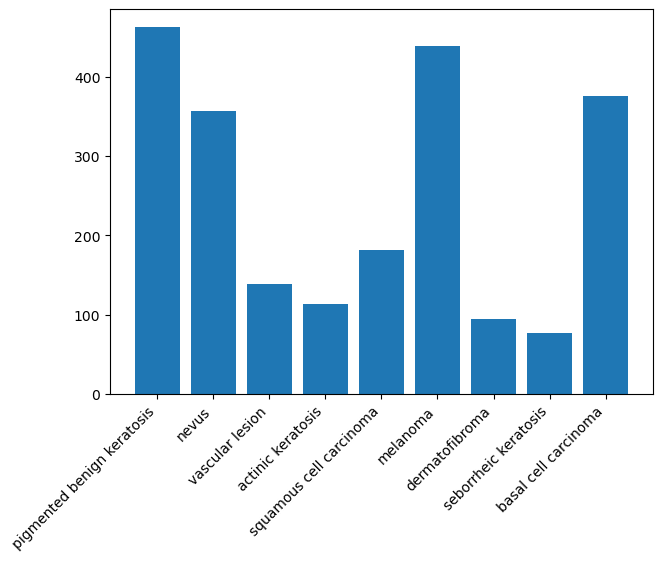

In [41]:
def count_images(directory):
    flag = 0
    total_images = []
    for root, dirs, files in os.walk(directory):
        if flag == 0:
            diseases = dirs
            flag = 1
            continue
        if flag == 1:
            img = 0
            for file in files:
                if file.endswith(('.jpg', '.jpeg')):
                    img += 1
            total_images.append(img)
    return diseases, total_images


diseases, total_images = count_images(data_dir_train)
plt.figure(figsize=(7,5))
plt.bar(x=diseases, height=total_images)
plt.xticks(rotation=45, ha='right')
plt.show()

#### - Which class has the least number of samples?
- 'seborrheic keratosis' has least number of samples (77 samples)

#### - Which classes dominate the data in terms proportionate number of samples?
- 'pigmented benign keratosis', 'melanoma', 'basa cell carcinoma', 'nevus'

#### **Rectifying the class imbalance**

In [42]:
# pip3 install Augmentor

In [43]:
path_to_training_dataset= data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset) + '/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /home/chinu/Desktop/MLAI/Course 8- Deep Learning/4. Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F68C05E2110>: 100%|██████████| 500/500 [00:04<00:00, 114.65 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to /home/chinu/Desktop/MLAI/Course 8- Deep Learning/4. Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F689B494C70>: 100%|██████████| 500/500 [00:04<00:00, 106.56 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to /home/chinu/Desktop/MLAI/Course 8- Deep Learning/4. Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F68C0731870>: 100%|██████████| 500/500 [00:04<00:00, 100.69 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to /home/chinu/Desktop/MLAI/Course 8- Deep Learning/4. Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F689B73B3D0>: 100%|██████████| 500/500 [00:35<00:00, 14.14 Samples/s]                  


Initialised with 357 image(s) found.
Output directory set to /home/chinu/Desktop/MLAI/Course 8- Deep Learning/4. Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F689B73AB60>: 100%|██████████| 500/500 [00:33<00:00, 14.88 Samples/s]                  


Initialised with 462 image(s) found.
Output directory set to /home/chinu/Desktop/MLAI/Course 8- Deep Learning/4. Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F68A012F880>: 100%|██████████| 500/500 [00:06<00:00, 76.07 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to /home/chinu/Desktop/MLAI/Course 8- Deep Learning/4. Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F68D1B47220>: 100%|██████████| 500/500 [00:15<00:00, 32.91 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to /home/chinu/Desktop/MLAI/Course 8- Deep Learning/4. Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F68A012F0D0>: 100%|██████████| 500/500 [00:06<00:00, 74.02 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to /home/chinu/Desktop/MLAI/Course 8- Deep Learning/4. Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F68D1B96D40>: 100%|██████████| 500/500 [00:06<00:00, 71.88 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [44]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [45]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list[:5]

['/home/chinu/Desktop/MLAI/Course 8- Deep Learning/4. Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026416.jpg_ea22758c-3f15-45a3-9157-9da4af04bdd9.jpg',
 '/home/chinu/Desktop/MLAI/Course 8- Deep Learning/4. Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026637.jpg_21d7be97-aa80-4e72-8223-73a51579c40e.jpg',
 '/home/chinu/Desktop/MLAI/Course 8- Deep Learning/4. Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024782.jpg_7f0f0164-10bf-4d21-bc90-aa4ac9ba6867.jpg',
 '/home/chinu/Desktop/MLAI/Course 8- Deep Learning/4. Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pi

In [46]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis']

In [47]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [48]:
# Creating Original_df
path_list_original = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_original = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict_original = dict(zip(path_list_original, lesion_list_original))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df.shape


(2239, 2)

In [49]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)
df2.shape, new_df.shape

/tmp/ipykernel_65893/1818201164.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


((4500, 2), (6739, 2))

In [50]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Training the model on the data created using Augmentor

In [51]:
batch_size = 32
img_height = 180
img_width = 180

####  Creating a training dataset

In [52]:
data_dir_train = pathlib.Path("/home/chinu/Desktop/MLAI/Course 8- Deep Learning/4. Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating a validation dataset

In [53]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [54]:
## Creating One - hot encoding for labels
num_classes = len(class_names)


def one_hot_encode_label(img, label):
    label = tf.one_hot(label, num_classes)
    return img, label


train_ds = train_ds.map(one_hot_encode_label)
val_ds = val_ds.map(one_hot_encode_label)
    

#### Creating the model (including normalization)

In [68]:
model = Sequential([
    layers.experimental.preprocessing.Rescaling(scale=1. / 255, input_shape=(img_height, img_width, 3)),
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

## My Findings:  
- With the help augmentor, 500 extra images got added in each class.  
- And these many sample dataset improved the model.  
- Training and validation accuracy is 67% and 62 % respectively.  
- Model is not overfitted any more.  
- Now I have added dropout and batchnormalisation layers in next model.  

In [70]:
model_1 = Sequential([
    layers.experimental.preprocessing.Rescaling(scale=1. / 255, input_shape=(img_height, img_width, 3)),
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])


#### Compile the model

In [72]:
model_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_15 (Ba  (None, 180, 180, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 90, 90, 16)       

#### Train the model

In [73]:
epochs = 30
history_1 = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


169/169 [==============================] - 113s 655ms/step - loss: 2.7296 - accuracy: 0.2570 - val_loss: 36.7213 - val_accuracy: 0.0898
Epoch 2/30
169/169 [==============================] - 116s 680ms/step - loss: 1.6939 - accuracy: 0.3585 - val_loss: 23.5485 - val_accuracy: 0.0950
Epoch 3/30
169/169 [==============================] - 114s 672ms/step - loss: 1.5734 - accuracy: 0.3976 - val_loss: 5.3290 - val_accuracy: 0.1730
Epoch 4/30
169/169 [==============================] - 116s 684ms/step - loss: 1.4924 - accuracy: 0.4164 - val_loss: 2.0844 - val_accuracy: 0.3608
Epoch 5/30
169/169 [==============================] - 121s 712ms/step - loss: 1.4445 - accuracy: 0.4405 - val_loss: 1.7349 - val_accuracy: 0.3623
Epoch 6/30
169/169 [==============================] - 127s 745ms/step - loss: 1.3941 - accuracy: 0.4540 - val_loss: 1.4164 - val_accuracy: 0.4618
Epoch 7/30
169/169 [==============================] - 166s 983ms/step - loss: 1.3548 - accuracy: 0.4625 - val_loss: 1.3886 - val_accu

####  Visualize the model results

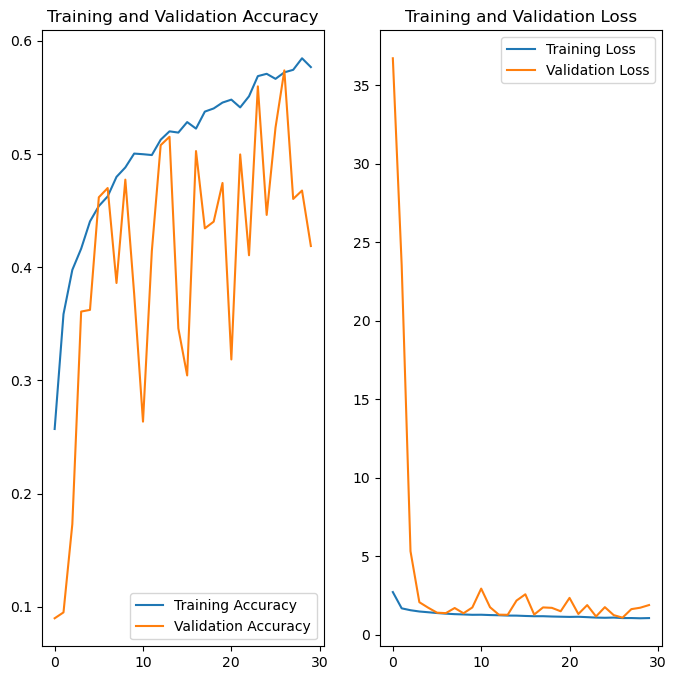

In [76]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### My Findings:
- Class rebalance definately made robust and better model.  
- But by adding dropout and batchnormalisation didnt help me in this case.
- Training and Validation accuracy both dropped in this case.
- Training accuracy is 57.7 %  
- Validation accuracy is 41.9%

